Изначально для решения задачи был выбран такой подход:
1. Кластеризация всех описаний (PL_Description) на основании всех 250к строк.
2. На основании размеченных данных можно будет определить рэнж столбца таргет для каждого из кластеров.

Но у полученных кластеров был слишком большой разброс таргет значений, что привело к мысли разметки классов в полуручном режиме исходя из минимизации разброса таргет значений по классу. Думаю, это было бы довольно долго, но, в принципе, возможно.

А что если применить гибридный подход? Вначале несколько классов можно проставить вручную, а когда распределение значений будет похоже на белый шум, воспользуемся моделью кластеризации для выделения классов у остатков данных.

In [85]:
import numpy as np
import pandas as pd
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
nltk.download('stopwords')

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [86]:
# Монтируем нужную папку гугл диска
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/SberLeasing_Test/Zadanie2/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/SberLeasing_Test/Zadanie2


In [142]:
# Открытие файла
input_df = pd.read_csv('./Zadacha 2.csv')

# Выделим full_df (train_df + val_df)
full_df = input_df.loc[input_df['PL_Description'].notnull() & input_df['target'].notnull()]
full_df = full_df[['PL_Description', 'target']].reset_index(drop=True)
print(full_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45309 entries, 0 to 45308
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PL_Description  45309 non-null  object 
 1   target          45309 non-null  float64
dtypes: float64(1), object(1)
memory usage: 708.1+ KB
None


                                          PL_Description        target
43039  Арктический челночный танкер с дедвейтом 42 00...  8.975026e+09
43041  Арктический челночный танкер с дедвейтом 42 00...  9.106557e+09
43042  Арктический челночный танкер с дедвейтом 42 00...  8.964859e+09


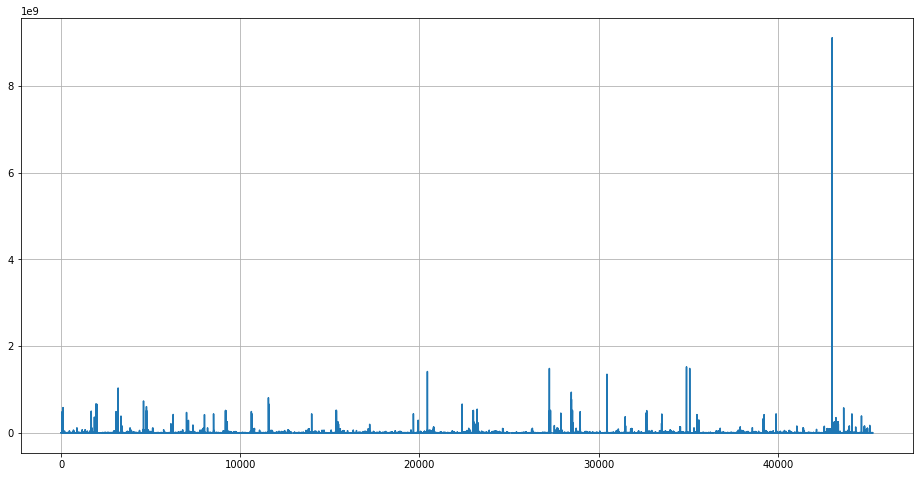

In [143]:
# Посмотрим распределение значений
full_df['target'].plot(figsize=(16, 8), grid=True)

# Выведем самые большие элементы дф
print(full_df.loc[full_df['target'] > float(2*10**9)])

# Присвоим им класс (0) - Арктический танкер
full_df.loc[full_df['target'] > float(2*10**9), 'Class'] = int(0)

                                          PL_Description        target  Class
35087  Самолет реактивный регионального класса модифи...  9.559456e+08    NaN
27247  Самолет реактивный регионального класса модифи...  9.652836e+08    NaN
34905  Самолет реактивный регионального класса модифи...  9.667600e+08    NaN
3180   Самолет реактивный регионального класса модифи...  1.037245e+09    NaN
27248  Самолет реактивный регионального класса модифи...  1.129991e+09    NaN
34907  Самолет реактивный регионального класса модифи...  1.200656e+09    NaN
27249  Самолет реактивный регионального класса модифи...  1.263362e+09    NaN
27252  Самолет реактивный регионального класса модифи...  1.296972e+09    NaN
34908  Самолет реактивный регионального класса модифи...  1.330979e+09    NaN
30470  Самолет реактивный регионального класса модифи...  1.354466e+09    NaN
34906  Самолет реактивный регионального класса модифи...  1.358868e+09    NaN
27250  Самолет реактивный регионального класса модифи...  1.4027

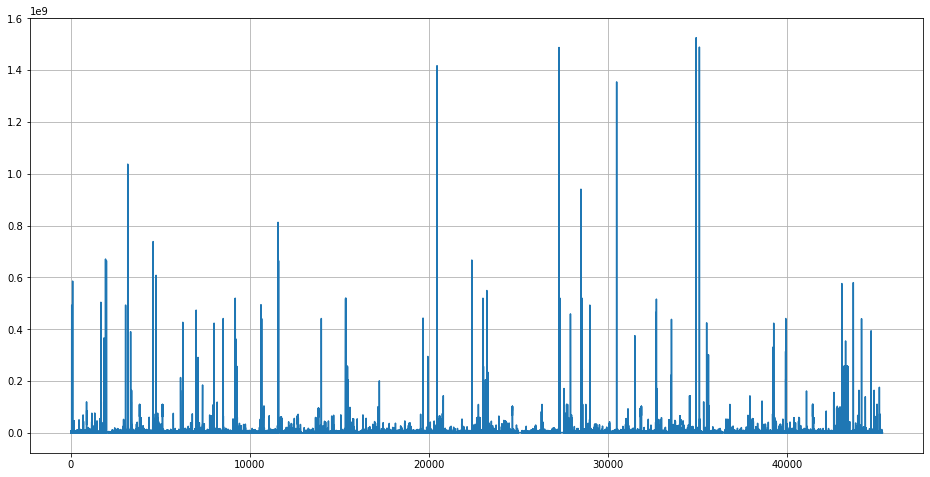

In [144]:
# Выведем новое распределение
new_values = full_df.loc[full_df['Class'].isnull()].reset_index(drop=True)
new_values['target'].plot(figsize=(16, 8), grid=True)

# Зададим новый предполагаемый класс и выведем его элементы
tmp_df = new_values.loc[new_values['target'] > float(0.95*10**9)]
print(tmp_df.sort_values(by=['target']))

# Исходя из вывода, новый класс (1) - Самолет реактивный. Присвоим класс
new_class = tmp_df['PL_Description'].tolist()
full_df.loc[full_df['PL_Description'].isin(new_class), 'Class'] = int(1)

                                          PL_Description  target  Class
180    Автомобиль бортовой ТР8499 Расторг_19.09.19 Из...     0.0    NaN
29673   Седельный тягач КАМАЗ 5490-S5 расторг 24.07.2019     0.0    NaN
29993  Полуприцеп-самосвал ТОНАР - 952301 Расторг_26....     0.0    NaN
30226                               Трактор БЕЛАРУС 82.1     0.0    NaN
30289     Самосвал МАЗ-6516С9-580-000 расторг 12.03.2020     0.0    NaN
...                                                  ...     ...    ...
14472    Фронтальный погрузчик HZM 220R Расторг 29.01.20     0.0    NaN
14595  ГРУЗОВОЙ-САМОСВАЛ FAW СА3310Р66K24T4E5 расторг...     0.0    NaN
14597             Самосвал КАМАЗ 65801-Т5 изъят 24.12.19     0.0    NaN
12692  Специализированное пассажирское ТС (13 мест) Г...     0.0    NaN
45258  Комбайн зерноуборочный самоходный КЗС-10К-26 Р...     0.0    NaN

[648 rows x 3 columns]


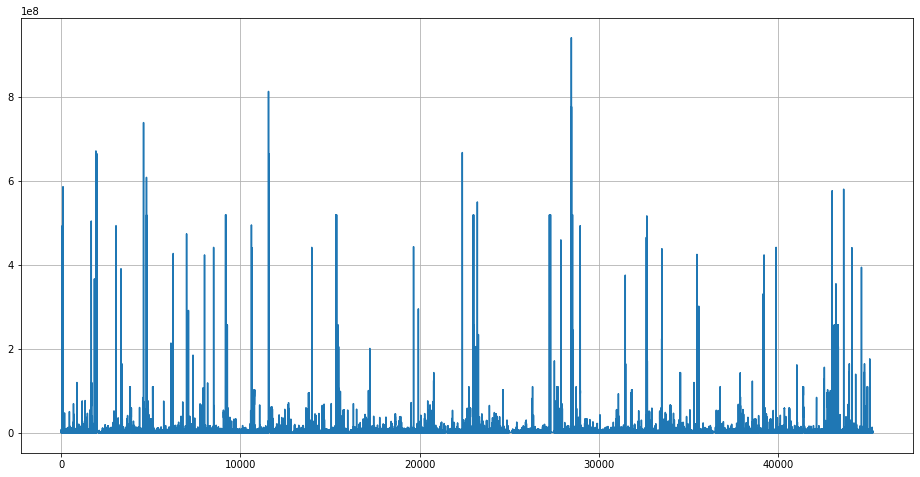

In [145]:
# Выведем новое распределение
new_values = full_df.loc[full_df['Class'].isnull()].reset_index(drop=True)
new_values['target'].plot(figsize=(16, 8), grid=True)

# Зададим новый предполагаемый класс и выведем его элементы
tmp_df = new_values.loc[new_values['target'] == float(0)]
print(tmp_df.sort_values(by=['target']))

# Исходя из вывода, новый класс (2) - Расторгнутые контракты. Присвоим класс
new_class = tmp_df['PL_Description'].tolist()
full_df.loc[full_df['PL_Description'].isin(new_class), 'Class'] = int(2)

                            PL_Description  target  Class
24120                 Автомобль Opel Astra    0.10    NaN
42305                        Форд Рэйнджер    1.00    NaN
8718        Вагон-дом Кедр -К-6-2 Столовая   83.05    NaN
8725           Вагон-столовая БСП Подсобка   83.05    NaN
14516            Вагон-дом Кедр -5 Сушилка   83.05    NaN
...                                    ...     ...    ...
14559            Вагон дом Кедр -5 сушилка   85.59    NaN
21830  Вагон дом Кедр -11 (сауна, санузел)   85.59    NaN
8692                    Вагон-дом Гжать-10   85.59    NaN
7461                    Вагон дом Кедр -4К   85.59    NaN
8694                     Вагон-дом Гжать-4   85.59    NaN

[114 rows x 3 columns]


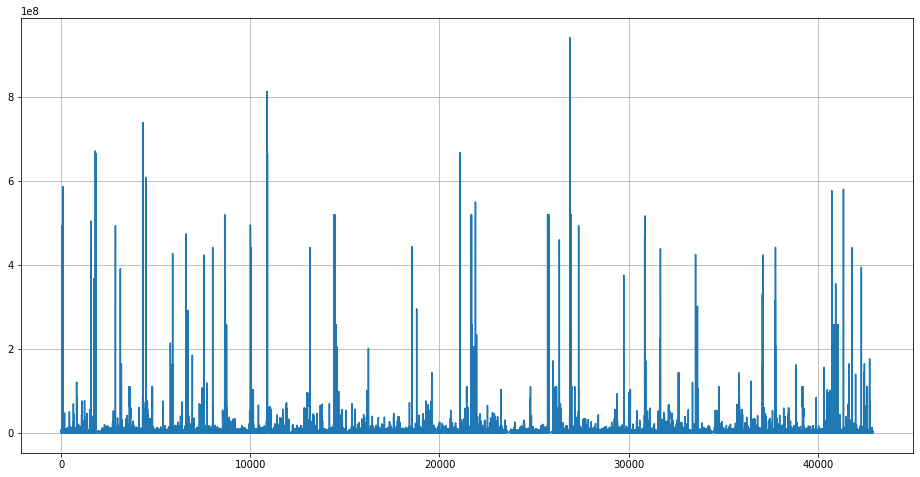

In [146]:
# Выведем новое распределение
new_values = full_df.loc[full_df['Class'].isnull()].reset_index(drop=True)
new_values['target'].plot(figsize=(16, 8), grid=True)

# Зададим новый предполагаемый класс и выведем его элементы
tmp_df = new_values.loc[new_values['target'] < float(9700)]
print(tmp_df.sort_values(by=['target']))

# Исходя из вывода, новый класс (3) - Дом-вагон. Присвоим класс
new_class = tmp_df['PL_Description'].tolist()
full_df.loc[full_df['PL_Description'].isin(new_class), 'Class'] = int(3)

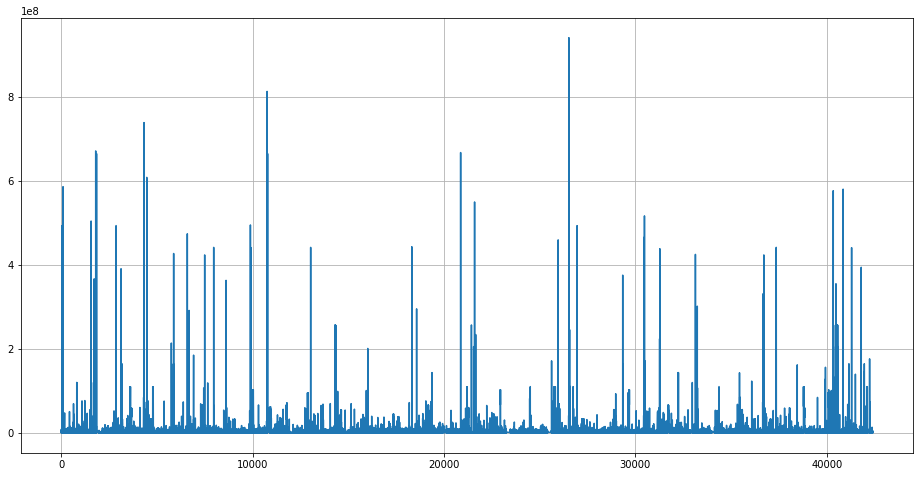

In [147]:
# Выведем новое распределение
new_values = full_df.loc[full_df['Class'].isnull()].reset_index(drop=True)
new_values['target'].plot(figsize=(16, 8), grid=True)

# Зададим новый предполагаемый класс и выведем его элементы
tmp_df = new_values.loc[new_values['target'] > float(1*10**7)]

# Очень много вагонов, присвоим им класс - (4)
subclass_lst = tmp_df.loc[(lambda tmp_df: tmp_df['PL_Description'].str.find('Вагон') != -1) or
                          (lambda tmp_df: tmp_df['PL_Description'].str.find('вагон') != -1), 'PL_Description'].tolist()
full_df.loc[full_df['PL_Description'].isin(subclass_lst), 'Class'] = int(4)

Cluster 9:['комлекс', 'технологический', 'камер']
Cluster 19:['комплект', 'вклмонтажный', 'рама']
Cluster 29:['отделениекамеры', 'газации', 'машинное']
Cluster 39:['противообледенительная', 'аэродромная', 'машина']
Cluster 49:['оборудование', 'водоподготовки', 'производства']
Cluster 59:['мусоровоз', 'рг', 'шасси']
Cluster 69:['нержавеющих', 'полировки', 'химической']
Cluster 79:['комплекс', 'посевной', 'аппаратностудийный']
Cluster 89:['полетов', 'разбора', 'комплексный']
Cluster 99:['компл', 'литьевая', 'ротационная']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45309 entries, 0 to 45308
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PL_Description  45309 non-null  object 
 1   target          45309 non-null  float64
 2   Class           6659 non-null   float64
dtypes: float64(2), object(1)
memory usage: 1.0+ MB
None


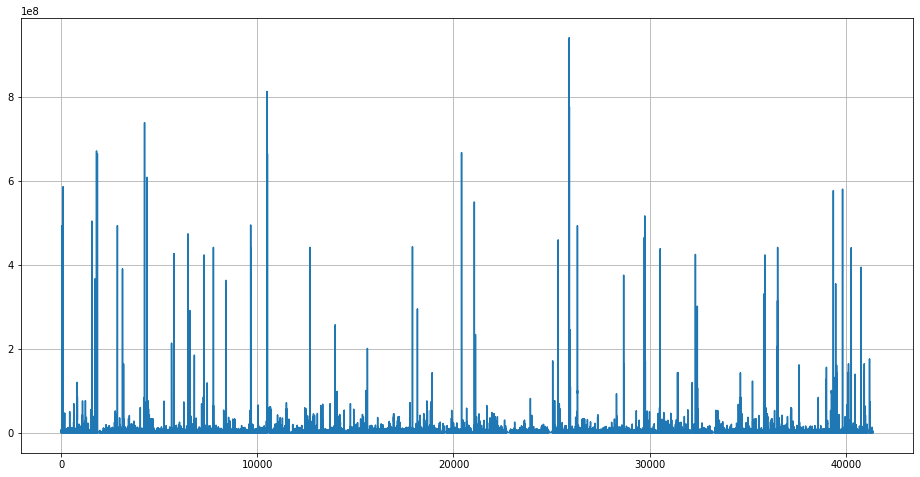

In [148]:
# Выведем новое распределение
new_values = full_df.loc[full_df['Class'].isnull()].reset_index(drop=True)
new_values['target'].plot(figsize=(16, 8), grid=True)

# Зададим новый предполагаемый диапазон значений и выведем его элементы
tmp_df = new_values.loc[new_values['target'] > float(1*10**7)]
# print(len(tmp_df))
# for i in tmp_df['PL_Description']:
#   print(i)

# Очень много абсолютно разных контрактов. Решим задачу кластеризации
def text_cleaning(line):
  '''Удалим все знаки препинания, цифры и сделаем только нижний регистр'''
  clean = re.sub(r'(\<(/?[^>]+)>)', ' ', line)
  clean = re.sub('[^а-яА-Я ]', '', clean)
  clean = clean.lower()
  return clean

# Очистка данных (вызов функции)
tmp_df['Text_for_cluster'] = tmp_df['PL_Description'].apply(text_cleaning)
texts = tmp_df['Text_for_cluster'].tolist()

# Стоп-слова модели
stopwords = nltk.corpus.stopwords.words('russian')
stopwords.extend(['х', 'тс', 'т', 'е', 'рсм', 'кв', 'м', 'рн', 'на', 'к'])

# Vectorizer
vectorizer = TfidfVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(texts)

# Количество кластеров
number_of_clusters = 100

# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
model = KMeans(n_clusters=number_of_clusters, 
               init='k-means++', 
               max_iter=300,
               n_init=5)
model.fit(X)

# Выведем полученные кластеры
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

counter = 0
for i in range(number_of_clusters):
    key_words = []
    for ind in order_centroids[i, :3]:
        key_words.append(terms[ind])

    counter += 1
    if counter % 10 == 0:
      print('Cluster {}:{}'.format(i, key_words))

# Создание списка кластеров
cluster = model.predict(X)

# Вставляем список в датафрейм
tmp_df['Class'] = cluster

# Не забываем прибавить к ряду 5, тк 5 классов уже выделены вручную
tmp_df['Class'] = tmp_df['Class'] + 5

# Добавляем классы в основной датафрейм
# # merge работает криво (левым соединение увеличивает кол-во строк)
# new_df = full_df.merge(tmp_df[['PL_Description', 'Class']], how='left',
#                        on='PL_Description')
# new_df.loc[new_df['Class_y'].notnull(), 'Class_x'] = new_df['Class_y']
# full_df = new_df

# Добавляем классы в основной датафрейм (пока циклом)
for i in tmp_df['PL_Description'].unique():
  full_df.loc[full_df['PL_Description'] == i, 'Class'] = tmp_df.loc[tmp_df['PL_Description'] == i, 'Class'].iloc[0]
print(full_df.info())

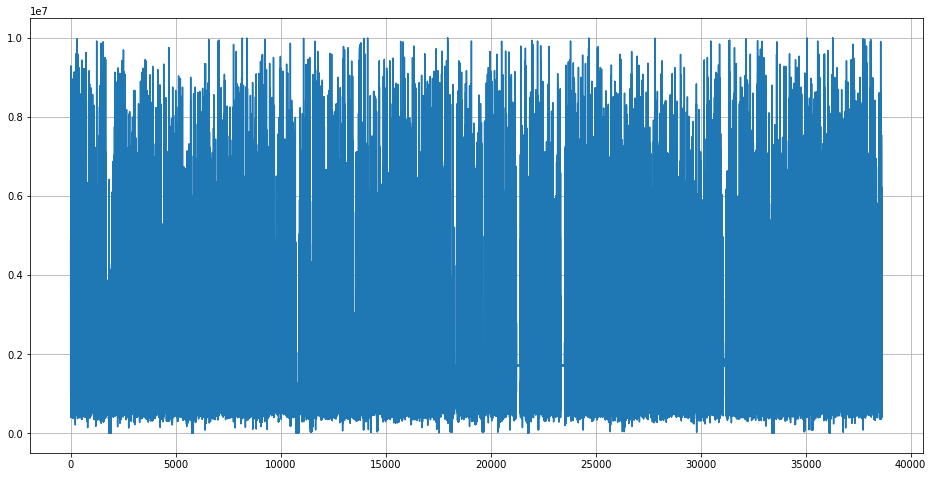

In [149]:
# Выведем новое распределение
new_values = full_df.loc[full_df['Class'].isnull()].reset_index(drop=True)
new_values['target'].plot(figsize=(16, 8), grid=True)

Итак, в ручном режиме было проставлено 5 классов:

(0) - Арктический танкер

(1) - Самолет реактивный

(2) - Расторгнутые контракты

(3) - Дом-вагон (маленький таргет)

(4) - Вагон

В автоматическом режиме было проставлено 100 классов. Всего - 105.

Следующий шаг - решение задачи классификации на основе полученных классов. Но что если не нужно классифицировать весь неразмеченный датафрейм, а только максимально похожие строки? В таком случае, при решении задачи классификации нужно добавить колонку показывающую процент схожести с классом, на основе которой оставить строки лишь с самым высоким процентом схожести.

In [150]:
# Для начала, необходимо откатать модель с помощью разметки валидационного дф
# Разбиение полного дф на трен и валидационный (для подсчета примерной точности)
full_train = full_df.loc[full_df['Class'].notnull()].reset_index(drop=True)

test_df = input_df.loc[(input_df['PL_Description'].notnull()) &
                       (input_df['target'].isnull())].reset_index(drop=True)

train_df, val_df = train_test_split(full_train, test_size=0.2)

# Мини проверка того, что в трейн дата есть все классы
print(len(train_df['Class'].unique()), len(val_df['Class'].unique()))

105 93


In [151]:
# Очистка данных
full_train['Clean_Text'] = full_train['PL_Description'].apply(text_cleaning)
train_df['Clean_Text'] = train_df['PL_Description'].apply(text_cleaning)
val_df['Clean_Text'] = val_df['PL_Description'].apply(text_cleaning)
test_df['Clean_Text'] = test_df['PL_Description'].apply(text_cleaning)

# Обучающие столбцы
texts = full_train['Clean_Text'].tolist()
texts_labels = full_train['Class'].tolist()

# Стоп-слова модели
stopwords = nltk.corpus.stopwords.words('russian')
stopwords.extend(['х', 'тс', 'т', 'е', 'рсм', 'кв', 'м', 'рн', 'на', 'к'])

# Accuracy on val_df: 0.9519519519519519
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('clf', RandomForestClassifier())
])

# # Accuracy on val_df: 0.9271771771771772
# text_clf = Pipeline([
#     ('tfidf', TfidfVectorizer(stop_words=stopwords)),
#     ('clf', SGDClassifier(loss='hinge', penalty='l2',
#                              alpha=1e-3, random_state=42))
# ])

# # Accuracy on val_df: 0.9316816816816816
# text_clf = Pipeline([
#     ('tfidf', TfidfVectorizer(stop_words=stopwords)),
#     ('clf', KNeighborsClassifier(n_neighbors=3))
# ])

# # Accuracy on val_df: 0.9271771771771772
# text_clf = Pipeline([
#     ('vect', CountVectorizer(stop_words=stopwords)),
#     ('tfidf', TfidfTransformer()),
#     ('clf', SGDClassifier(loss='hinge', penalty='l2',
#                             alpha=1e-3, random_state=42)),
# ])

text_clf.fit(texts, texts_labels)

# # Accuracy on val_df: 0.9519519519519519 (RandomForestClassifier())
# accuracy = text_clf.score(val_df['Clean_Text'].tolist(), val_df['Class'].tolist())
# print('Accuracy on val_df: {}'.format(accuracy))

# Предсказание на val_data (для дальнейшей проверки результатов)
res_val = text_clf.predict(val_df['Clean_Text'].tolist())
proba_val = text_clf.predict_proba(val_df['Clean_Text'].tolist())
max_proba_val = np.amax(proba_val, axis = 1).tolist()

# Заполнение данных в дф val
val_df['Pred_Class'] = res_val
val_df['Proba_Max'] = max_proba_val

# Удалим значения предсказанных классов val, если процент меньше 93%
val_df.loc[val_df['Proba_Max'] < float(0.93), 'Pred_Class'] = np.nan

# Predict
res = text_clf.predict(test_df['Clean_Text'].tolist())
proba = text_clf.predict_proba(test_df['Clean_Text'].tolist())
max_proba = np.amax(proba, axis = 1).tolist()

# Заполнение данных в дф
test_df['Pred_Class'] = res
test_df['Proba_Max'] = max_proba
print(test_df.info())
print(test_df['Proba_Max'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197276 entries, 0 to 197275
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SubjectId       86162 non-null   object 
 1   PL_Description  197276 non-null  object 
 2   target          0 non-null       float64
 3   Clean_Text      197276 non-null  object 
 4   Pred_Class      197276 non-null  float64
 5   Proba_Max       197276 non-null  float64
dtypes: float64(3), object(3)
memory usage: 9.0+ MB
None
count    197276.000000
mean          0.745404
std           0.192376
min           0.170000
25%           0.600000
50%           0.840000
75%           0.854424
max           1.000000
Name: Proba_Max, dtype: float64


In [152]:
# Удалим значения предсказанных классов, если процент меньше 93%
test_df.loc[test_df['Proba_Max'] < float(0.93), 'Pred_Class'] = np.nan
test_df = test_df.rename(columns={'Pred_Class': 'Class'})
test_df_common = test_df.copy()
print(test_df.info())
print(test_df['Proba_Max'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197276 entries, 0 to 197275
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SubjectId       86162 non-null   object 
 1   PL_Description  197276 non-null  object 
 2   target          0 non-null       float64
 3   Clean_Text      197276 non-null  object 
 4   Class           33638 non-null   float64
 5   Proba_Max       197276 non-null  float64
dtypes: float64(3), object(3)
memory usage: 9.0+ MB
None
count    197276.000000
mean          0.745404
std           0.192376
min           0.170000
25%           0.600000
50%           0.840000
75%           0.854424
max           1.000000
Name: Proba_Max, dtype: float64


Задача классификации решена.

Следующая задача - кластеризировать оставшиеся строки. Будем это делать с помощью уже применявшихся алгоритмов. Количество кластеров подберем пропорционально прошлой модели.

In [153]:
# Выполним кластеризацию на основе оставшихся данных
# Очистка данных (вызов функции)
new_values['Text_for_cluster'] = new_values['PL_Description'].apply(text_cleaning)
texts = new_values['Text_for_cluster'].tolist()

# Vectorizer
vectorizer = TfidfVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(texts)

# Количество кластеров (подобрано пропорционально прошлой модели)
number_of_clusters = 500

# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
model = KMeans(n_clusters=number_of_clusters, 
               init='k-means++', 
               max_iter=300,
               n_init=5)
model.fit(X)

# Выведем полученные кластеры
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

counter = 0
for i in range(number_of_clusters):
    key_words = []
    for ind in order_centroids[i, :3]:
        key_words.append(terms[ind])

    counter += 1
    if counter % 20 == 0:
      print('Cluster {}:{}'.format(i, key_words))

# Создание списка кластеров
cluster = model.predict(X)

# Вставляем список в датафрейм
new_values['Class'] = cluster

# Не забываем прибавить к ряду 105, тк 105 классов уже выделены вручную
new_values['Class'] = new_values['Class'] + 105

# Добавляем классы в основной датафрейм
# # merge работает криво (левым соединение увеличивает кол-во строк)
# new_df = full_df.merge(tmp_df[['PL_Description', 'Class']], how='left',
#                        on='PL_Description')
# new_df.loc[new_df['Class_y'].notnull(), 'Class_x'] = new_df['Class_y']
# full_df = new_df

# Добавляем классы в основной датафрейм (пока циклом)
for i in new_values['PL_Description'].unique():
  full_df.loc[full_df['PL_Description'] == i, 'Class'] = new_values.loc[new_values['PL_Description'] == i, 'Class'].iloc[0]
print(full_df.info())

Cluster 19:['самосвал', 'камаз', 'расторг']
Cluster 39:['универсал', 'легковой', 'расторг']
Cluster 59:['хэтчбек', 'легковой', 'автомобиль']
Cluster 79:['нефаз', 'полуприцеп', 'самосвал']
Cluster 99:['маз', 'самосвал', 'грузовой']
Cluster 119:['маз', 'тягач', 'седельный']
Cluster 139:['спецпассажирский', 'уаз', 'автомобиль']
Cluster 159:['грузовые', 'вис', 'фургоны']
Cluster 179:['борона', 'дисковая', 'тяжелая']
Cluster 199:['рефрижератор', 'полуприцеп', 'ху']
Cluster 219:['колесный', 'экскаватор', 'одноковшовый']
Cluster 239:['марица', 'пресса', 'ярус']
Cluster 259:['исток', 'фургон', 'грузовой']
Cluster 279:['урал', 'тягач', 'седельный']
Cluster 299:['дорожная', 'машина', 'комбинированная']
Cluster 319:['гст', 'тм', 'бульдозер']
Cluster 339:['специальный', 'прицеп', 'подметальноуборочный']
Cluster 359:['зернотуковая', 'сеялка', 'рядовая']
Cluster 379:['тип', 'дорожная', 'комбинированная']
Cluster 399:['самоходная', 'машина', 'экскаватор']
Cluster 419:['тсм', 'сеялка', 'сн']
Cluster 4

Очередная кластеризация успешно завершена.

Следующая задача - проставить классы у оставшихся данных в тест_дата (с помощью уже использованного алгоритма классификации)

In [0]:
full_train = new_values.reset_index(drop=True)
test_df = test_df.loc[test_df['Class'].isnull()].reset_index(drop=True)

# Очистка данных
full_train['Clean_Text'] = full_train['PL_Description'].apply(text_cleaning)

# Обучающие столбцы
texts = full_train['Clean_Text'].tolist()
texts_labels = full_train['Class'].tolist()

# Accuracy on val_df: 0.9519519519519519
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('clf', RandomForestClassifier())
])

text_clf.fit(texts, texts_labels)

# Predict
res = text_clf.predict(test_df['Clean_Text'].tolist())
proba = text_clf.predict_proba(test_df['Clean_Text'].tolist())
max_proba = np.amax(proba, axis = 1).tolist()

# Заполнение данных в дф
test_df['Class'] = res
test_df_common.loc[test_df_common['Class'].isnull(), 'Class'] = res

Наконец, классы проставлены.

Единственным правильным решением по следующему действию считаю - вычисление медианного значения таргет по каждому классу и проставление их в неразмеченный датафрейм.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197276 entries, 0 to 197275
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SubjectId       86162 non-null   object 
 1   PL_Description  197276 non-null  object 
 2   target          197276 non-null  float64
 3   Clean_Text      197276 non-null  object 
 4   Class           197276 non-null  float64
 5   Proba_Max       197276 non-null  float64
dtypes: float64(3), object(3)
memory usage: 9.0+ MB
None


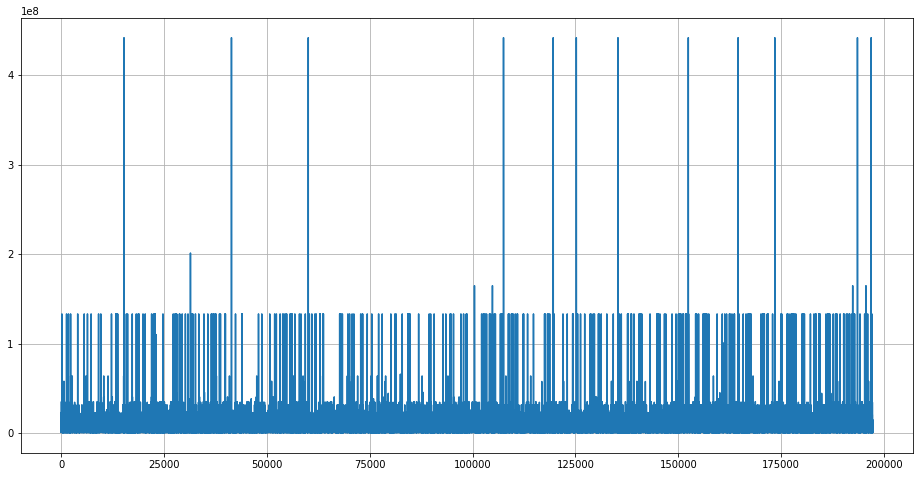

In [162]:
for i in full_df['Class'].unique():
  test_df_common.loc[test_df_common['Class'] == i, 'target'] = full_df.loc[full_df['Class'] == i, 'target'].median()
print(test_df_common.info())
test_df_common['target'].plot(figsize=(16, 8), grid=True)
test_df_common[['SubjectId', 'PL_Description', 'target']].to_csv('./Submission2.csv')